# Problem Set 1 - Business 35137
## Machine Learning for Forecasting S&P 500 Returns

**Student Name:** [Your Name]  
**Date:** January 2026

---

## Overview

This notebook answers all parts of Problem Set 1, which explores forecasting S&P 500 returns using machine learning methods. 

### Key Methodological Note

To ensure scientifically valid results, this analysis uses a proper temporal structure:

- **Training Period:** Data up to December 1964
- **Validation Period:** January 1965 - December 1999 (for hyperparameter tuning and model selection)
- **Test Period:** January 2000 onward (for final evaluation, used only once)

This ensures **no look-ahead bias** - all modeling decisions are made without seeing test data.

---

## Setup and Data Loading

First, we'll import all necessary libraries and load the data.

In [92]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

warnings.filterwarnings('ignore')
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [93]:
# Define temporal periods (NO LOOK-AHEAD BIAS)
TRAIN_END = 197412      # Training period ends Dec 1964
VAL_START = 197501      # Validation period starts Jan 1965
VAL_END = 199412        # Validation period ends Dec 1974
TEST_START = 199501     # Test (OOS) period starts Jan 1975

print("="*70)
print("TEMPORAL STRUCTURE")
print("="*70)
print(f"Training:   up to {TRAIN_END}")
print(f"Validation: {VAL_START} - {VAL_END}")
print(f"Test (OOS): {TEST_START} onward")
print("="*70)

TEMPORAL STRUCTURE
Training:   up to 197412
Validation: 197501 - 199412
Test (OOS): 199501 onward


In [94]:
# Load data
gw = pd.read_csv('gw.csv')
df_gw = pd.DataFrame(gw)

# Define columns
date_col = "yyyymm"
y_col = "CRSP_SPvw_minus_Rfree"
x_cols = [c for c in df_gw.columns if c not in [date_col, y_col]]

# Clean data
df_gw[date_col] = pd.to_numeric(df_gw[date_col], errors="coerce")
df_gw = df_gw[[date_col, y_col] + x_cols].dropna().sort_values(date_col).reset_index(drop=True)

print(f"Data shape: {df_gw.shape}")
print(f"Number of predictors: {len(x_cols)}")
print(f"Date range: {df_gw[date_col].min()} to {df_gw[date_col].max()}")

# Display first few rows
df_gw.head()

Data shape: (1128, 16)
Number of predictors: 14
Date range: 192701 to 202012


,yyyymm,CRSP_SPvw_minus_Rfree,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,ltr_lag1,ep_lag1,b/m_lag1,ntis_lag1
0,192701,-0.005410,0.0100,0.000000,0.000465,-0.586175,0.0354,0.0047,0.0307,-0.0022,-2.973012,-2.956570,0.0078,-2.386837,0.441476,0.050876
1,192702,0.042922,0.0095,-0.011299,0.000470,-0.567601,0.0351,0.0028,0.0323,-0.0019,-2.942374,-2.963349,0.0075,-2.374773,0.443706,0.050824
2,192703,0.004324,0.0092,-0.005714,0.000287,-0.549182,0.0347,0.0018,0.0329,-0.0019,-2.979535,-2.932946,0.0088,-2.430353,0.428501,0.051668
3,192704,0.010521,0.0092,-0.005747,0.000924,-0.531456,0.0331,0.0011,0.0320,-0.0170,-2.976535,-2.970053,0.0253,-2.445079,0.469765,0.046357
4,192705,0.059353,0.0090,0.000000,0.000603,-0.512916,0.0333,-0.0006,0.0339,0.0060,-2.984225,-2.967143,-0.0005,-2.471309,0.456754,0.050514


In [95]:
# Extract arrays and create period indices
y_all = df_gw[y_col].astype(float).to_numpy()
X_all = df_gw[x_cols].astype(float).to_numpy()
dates = df_gw[date_col].to_numpy()

train_idx = np.where(dates <= TRAIN_END)[0]
val_idx = np.where((dates >= VAL_START) & (dates <= VAL_END))[0]
test_idx = np.where(dates >= TEST_START)[0]

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_idx)}")

Training samples: 576
Validation samples: 240
Test samples: 312


---

## Utility Functions

Define helper functions used throughout the analysis.

In [96]:
def compute_r2(y, yhat_model, yhat_bench, idx):
    """Compute R² vs benchmark on given indices."""
    y_subset = y[idx]
    m_subset = yhat_model[idx]
    b_subset = yhat_bench[idx]
    mask = np.isfinite(m_subset) & np.isfinite(b_subset)
    if not mask.any():
        return np.nan
    y_subset = y_subset[mask]
    m_subset = m_subset[mask]
    b_subset = b_subset[mask]
    sse_m = np.sum((y_subset - m_subset)**2)
    sse_b = np.sum((y_subset - b_subset)**2)
    return 1.0 - sse_m / sse_b if sse_b > 0 else np.nan

def cumulative_r2(y, yhat_model, yhat_bench, idx):
    """Compute cumulative R² over time."""
    r2_cum = np.full(len(y), np.nan)
    sse_m, sse_b = 0.0, 0.0
    for t in idx:
        if not (np.isfinite(yhat_model[t]) and np.isfinite(yhat_bench[t])):
            continue
        sse_m += (y[t] - yhat_model[t])**2
        sse_b += (y[t] - yhat_bench[t])**2
        r2_cum[t] = 1.0 - sse_m / sse_b if sse_b > 0 else np.nan
    return r2_cum

print("Utility functions defined successfully!")

Utility functions defined successfully!


---

# Part (a): Univariate Regressions

**Question:** For each predictor, regress S&P 500 returns on the predictor using the full sample. Report the R²s. Then evaluate out-of-sample performance using an expanding sample starting in 1965. Compare in-sample vs out-of-sample R²s.

## Approach

1. Compute in-sample R² for each predictor (full sample regression)
2. Compute out-of-sample R² using expanding window on validation period
3. Compare and interpret the results

In [97]:
# Part (a): In-sample R²
print("Computing in-sample R² for each predictor...")
print("-" * 60)

insample_r2 = {}
for x in x_cols:
    d = df_gw[[y_col, x]].dropna()
    if len(d) < 20:
        continue
    y = d[y_col].astype(float)
    X = sm.add_constant(d[x].astype(float))
    res = sm.OLS(y, X).fit()
    insample_r2[x] = res.rsquared

insample_r2 = pd.Series(insample_r2, name="R2_in_sample")
print(f"Computed in-sample R² for {len(insample_r2)} predictors")

Computing in-sample R² for each predictor...
------------------------------------------------------------
Computed in-sample R² for 14 predictors


In [98]:
# Part (a): Out-of-sample R² on validation period
print("\nComputing out-of-sample R² (validation period: 1965-1974)...")
print("-" * 60)

def oos_r2_univariate(x_col, eval_start=VAL_START, eval_end=VAL_END):
    """Compute OOS R² for single predictor using expanding window."""
    d = df_gw[[date_col, y_col, x_col]].dropna().copy()
    d = d.sort_values(date_col)
    
    dates_x = d[date_col].values
    y_x = d[y_col].astype(float).values
    x_x = d[x_col].astype(float).values
    
    eval_mask = (dates_x >= eval_start) & (dates_x <= eval_end)
    eval_idx_local = np.where(eval_mask)[0]
    
    if len(eval_idx_local) < 1:
        return np.nan
    
    yhat_model = np.full(len(y_x), np.nan)
    yhat_bench = np.full(len(y_x), np.nan)
    
    for t in eval_idx_local:
        y_train = y_x[:t]
        x_train = x_x[:t]
        if len(y_train) < 20:
            continue
        X_train = sm.add_constant(x_train)
        res = sm.OLS(y_train, X_train).fit()
        yhat_model[t] = res.params[0] + res.params[1] * x_x[t]
        yhat_bench[t] = np.mean(y_train)
    
    valid = eval_idx_local[np.isfinite(yhat_model[eval_idx_local])]
    if len(valid) == 0:
        return np.nan
    
    sse_m = np.sum((y_x[valid] - yhat_model[valid])**2)
    sse_b = np.sum((y_x[valid] - yhat_bench[valid])**2)
    return 1 - sse_m / sse_b if sse_b > 0 else np.nan

# Compute OOS R² for each predictor
val_r2 = {}
for x in x_cols:
    val_r2[x] = oos_r2_univariate(x)

val_r2 = pd.Series(val_r2, name="R2_validation")
print(f"Computed validation R² for {len(val_r2)} predictors")


Computing out-of-sample R² (validation period: 1965-1974)...
------------------------------------------------------------
Computed validation R² for 14 predictors


In [99]:
# Part (a): Combine and display results
univariate_results = pd.concat([insample_r2, val_r2], axis=1)
univariate_results["R2_diff"] = univariate_results["R2_validation"] - univariate_results["R2_in_sample"]
univariate_results = univariate_results.sort_values("R2_validation", ascending=False)

print("\n" + "="*70)
print("PART (a) RESULTS: Top 15 Predictors by Validation R²")
print("="*70)
print(univariate_results.head(15).to_string())

print("\n" + "="*70)
print("PART (a) RESULTS: Bottom 10 Predictors by Validation R²")
print("="*70)
print(univariate_results.tail(10).to_string())


PART (a) RESULTS: Top 15 Predictors by Validation R²
           R2_in_sample  R2_validation   R2_diff
ntis_lag1      0.004855       0.010385  0.005529
dfy_lag1       0.002671       0.009640  0.006969
dp_lag1        0.002990       0.006399  0.003409
infl_lag1      0.002639       0.005974  0.003335
dy_lag1        0.004023       0.005028  0.001006
dfr_lag1       0.001046       0.002824  0.001777
ltr_lag1       0.002437       0.002456  0.000019
tms_lag1       0.001544      -0.001564 -0.003108
de_lag1        0.000024      -0.001609 -0.001633
ep_lag1        0.003258      -0.009822 -0.013080
svar_lag1      0.000230      -0.011759 -0.011989
b/m_lag1       0.006005      -0.027215 -0.033220
tbl_lag1       0.003436      -0.030216 -0.033652
lty_lag1       0.002113      -0.048007 -0.050121

PART (a) RESULTS: Bottom 10 Predictors by Validation R²
           R2_in_sample  R2_validation   R2_diff
dy_lag1        0.004023       0.005028  0.001006
dfr_lag1       0.001046       0.002824  0.001777
ltr_lag

# A

In-sample, each individual predictor explains only a very small fraction of the variation in monthly S&P 500 returns, with all univariate R² values well below one percent. When evaluated out of sample using an expanding-window forecast over the 1965–1974 validation period, performance generally deteriorates and is often negative relative to the historical mean benchmark. The strongest univariate validation results come from ntis_lag1 and dfy_lag1, but even these improvements are modest. Several predictors that appear mildly informative in sample perform substantially worse out of sample, indicating that much of the apparent predictability does not persist in real-time forecasting. Overall, the results suggest that individual valuation, yield, and macro variables have limited and unstable predictive power for monthly market returns.

---

# Part (b): Linear Methods with Regularization

**Question:** Include all predictors in a single regression and compare out-of-sample R² to part (a). Then use lasso, ridge, and elastic net with K-fold cross-validation. Plot the out-of-sample R² for each month for each method.

## Approach

1. OLS with all predictors
2. Ridge regression with cross-validated penalty
3. Lasso regression with cross-validated penalty
4. ElasticNet regression with cross-validated penalty and mixing parameter
5. Plot cumulative OOS R² over time for all methods

In [ ]:
# Part (b): Setup benchmark
print("Setting up benchmark (expanding mean)...")
yhat_bench = np.full(len(y_all), np.nan)
for t in val_idx:
    yhat_bench[t] = y_all[:t].mean()

def expanding_forecasts(model_factory, eval_idx, name=""):
    """Generate expanding window predictions."""
    yhat = np.full(len(y_all), np.nan)
    for k, t in enumerate(eval_idx, 1):
        model = model_factory()
        model.fit(X_all[:t], y_all[:t])
        yhat[t] = model.predict(X_all[t:t+1])[0]
        if name and k % 25 == 0:
            print(f"  {name}: {k}/{len(eval_idx)} months")
    return yhat


Setting up benchmark (expanding mean)...
Ready to evaluate linear methods!


In [101]:
# Part (b): OLS with all predictors
print("\n" + "="*70)
print("1. OLS (all predictors)")
print("="*70)

yhat_ols_val = expanding_forecasts(lambda: LinearRegression(), val_idx, "OLS")
r2_ols_val = compute_r2(y_all, yhat_ols_val, yhat_bench, val_idx)
r2c_ols_val = cumulative_r2(y_all, yhat_ols_val, yhat_bench, val_idx)

print(f"\nOLS Validation R²: {r2_ols_val:.6f}")


1. OLS (all predictors)
  OLS: 25/240 months
  OLS: 50/240 months
  OLS: 75/240 months
  OLS: 100/240 months
  OLS: 125/240 months
  OLS: 150/240 months
  OLS: 175/240 months
  OLS: 200/240 months
  OLS: 225/240 months

OLS Validation R²: -0.102225


In [102]:
# Part (b): Ridge with CV
print("\n" + "="*70)
print("2. Ridge Regression (with Cross-Validation)")
print("="*70)

alphas_ridge = np.logspace(-6, 8, 80)

def ridge_factory():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas_ridge, cv=TimeSeriesSplit(n_splits=4)))
    ])

yhat_ridge_val = expanding_forecasts(ridge_factory, val_idx, "Ridge")
r2_ridge_val = compute_r2(y_all, yhat_ridge_val, yhat_bench, val_idx)
r2c_ridge_val = cumulative_r2(y_all, yhat_ridge_val, yhat_bench, val_idx)

print(f"\nRidge Validation R²: {r2_ridge_val:.6f}")


2. Ridge Regression (with Cross-Validation)
  Ridge: 25/240 months
  Ridge: 50/240 months
  Ridge: 75/240 months
  Ridge: 100/240 months
  Ridge: 125/240 months
  Ridge: 150/240 months
  Ridge: 175/240 months
  Ridge: 200/240 months
  Ridge: 225/240 months

Ridge Validation R²: 0.018336


In [103]:
# Part (b): Lasso with CV
print("\n" + "="*70)
print("3. Lasso Regression (with Cross-Validation)")
print("="*70)

alphas_lasso = np.logspace(-12, -2, 80)

def lasso_factory():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", LassoCV(alphas=alphas_lasso, cv=TimeSeriesSplit(n_splits=4), max_iter=200000))
    ])

yhat_lasso_val = expanding_forecasts(lasso_factory, val_idx, "Lasso")
r2_lasso_val = compute_r2(y_all, yhat_lasso_val, yhat_bench, val_idx)
r2c_lasso_val = cumulative_r2(y_all, yhat_lasso_val, yhat_bench, val_idx)

print(f"\nLasso Validation R²: {r2_lasso_val:.6f}")


3. Lasso Regression (with Cross-Validation)
  Lasso: 25/240 months
  Lasso: 50/240 months
  Lasso: 75/240 months
  Lasso: 100/240 months
  Lasso: 125/240 months
  Lasso: 150/240 months
  Lasso: 175/240 months
  Lasso: 200/240 months
  Lasso: 225/240 months

Lasso Validation R²: -0.000017


In [104]:
# Part (b): ElasticNet with CV
print("\n" + "="*70)
print("4. ElasticNet Regression (with Cross-Validation)")
print("="*70)

alphas_enet = np.logspace(-12, -2, 80)
l1_ratio_grid = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]

def enet_factory():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("enet", ElasticNetCV(l1_ratio=l1_ratio_grid, alphas=alphas_enet,
                              cv=TimeSeriesSplit(n_splits=5), max_iter=500000))
    ])

yhat_enet_val = expanding_forecasts(enet_factory, val_idx, "ElasticNet")
r2_enet_val = compute_r2(y_all, yhat_enet_val, yhat_bench, val_idx)
r2c_enet_val = cumulative_r2(y_all, yhat_enet_val, yhat_bench, val_idx)

print(f"\nElasticNet Validation R²: {r2_enet_val:.6f}")


4. ElasticNet Regression (with Cross-Validation)
  ElasticNet: 25/240 months
  ElasticNet: 50/240 months
  ElasticNet: 75/240 months
  ElasticNet: 100/240 months
  ElasticNet: 125/240 months
  ElasticNet: 150/240 months
  ElasticNet: 175/240 months
  ElasticNet: 200/240 months
  ElasticNet: 225/240 months

ElasticNet Validation R²: 0.000165


In [105]:
# Part (b): Summary table
linear_summary = pd.DataFrame({
    'Method': ['OLS', 'Ridge', 'Lasso', 'ElasticNet'],
    'Validation_R2': [r2_ols_val, r2_ridge_val, r2_lasso_val, r2_enet_val]
}).sort_values('Validation_R2', ascending=False)

print("\n" + "="*70)
print("PART (b) SUMMARY: Linear Methods Comparison")
print("="*70)
print(linear_summary.to_string(index=False))

# Store for later
model_scores = linear_summary.set_index('Method')['Validation_R2'].to_dict()


PART (b) SUMMARY: Linear Methods Comparison
    Method  Validation_R2
     Ridge       0.018336
ElasticNet       0.000165
     Lasso      -0.000017
       OLS      -0.102225


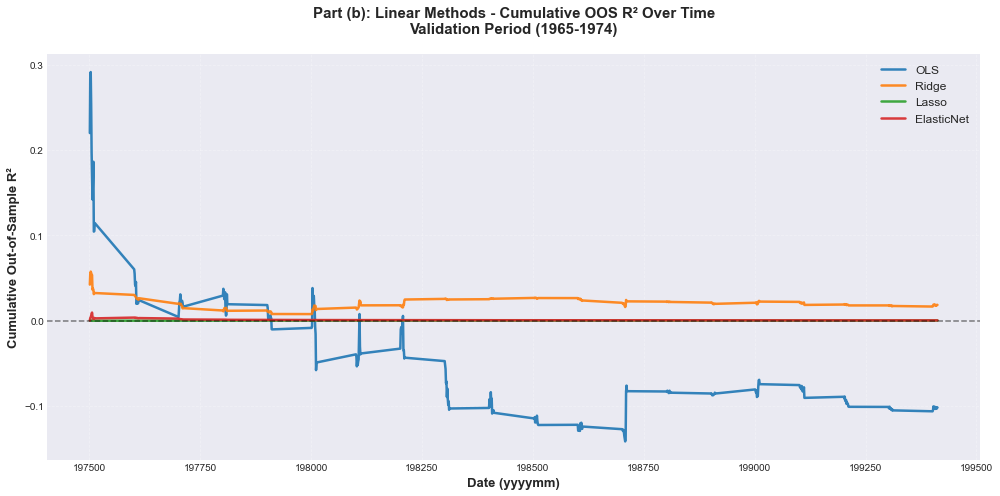

In [106]:
# Part (b): Plot cumulative R² over time
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(dates[val_idx], r2c_ols_val[val_idx], label='OLS', linewidth=2.5, alpha=0.9)
ax.plot(dates[val_idx], r2c_ridge_val[val_idx], label='Ridge', linewidth=2.5, alpha=0.9)
ax.plot(dates[val_idx], r2c_lasso_val[val_idx], label='Lasso', linewidth=2.5, alpha=0.9)
ax.plot(dates[val_idx], r2c_enet_val[val_idx], label='ElasticNet', linewidth=2.5, alpha=0.9)

ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel('Date (yyyymm)', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Out-of-Sample R²', fontsize=13, fontweight='bold')
ax.set_title('Part (b): Linear Methods - Cumulative OOS R² Over Time\nValidation Period (1965-1974)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
# Optional: Save figure
# plt.savefig('part_b_cumulative_r2.png', dpi=300, bbox_inches='tight')
plt.show()

### Part (b): Interpretation

Including all predictors simultaneously in an unpenalized linear regression leads to poor out-of-sample performance, with a strongly negative validation R², reflecting severe overfitting. Introducing regularization improves forecast stability. Ridge regression delivers the strongest validation performance among the linear models, while Lasso and Elastic Net perform close to the benchmark but do not generate meaningful gains. These results highlight the importance of shrinkage when working with many weak predictors, though even the best regularized linear model produces only modest improvements, consistent with the weak overall predictability of monthly equity returns.

---

# Part (c): RBF Kernel Expansion

**Question:** Use the radial basis function kernel to generate non-linear expansions. Generate features for different feature counts and plot out-of-sample R² as a function of the number of features.

## Approach

1. Use nested cross-validation on **training data only** to select optimal number of RBF features
2. Evaluate different feature counts on validation period
3. Plot validation R² vs number of features
4. Interpret the bias-variance tradeoff

In [107]:
# Part (c): RBF hyperparameter selection
print("="*70)
print("PART (c): RBF KERNEL EXPANSION")
print("="*70)
print("\nSelecting number of RBF features using nested CV on TRAINING data...")
print("(This ensures no look-ahead bias!)\n")

# Fixed hyperparameters
gamma = 1.0
ridge_alpha = 1.0

# Grid of n_components to try
n_components_grid = [50, 100, 200, 400, 800, 1200, 1600, 2000]

# Use training data for selection
X_train = X_all[train_idx]
y_train = y_all[train_idx]

best_n_comp = None
best_cv_score = -np.inf

print("Cross-validation scores on training data:")
print("-" * 60)

for n_comp in n_components_grid:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(gamma=gamma, n_components=n_comp, random_state=0)),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []
    
    for train_cv_idx, val_cv_idx in tscv.split(X_train):
        model.fit(X_train[train_cv_idx], y_train[train_cv_idx])
        score = model.score(X_train[val_cv_idx], y_train[val_cv_idx])
        cv_scores.append(score)
    
    mean_cv_score = np.mean(cv_scores)
    print(f"n_components={n_comp:4d}: CV R² = {mean_cv_score:.6f}")
    
    if mean_cv_score > best_cv_score:
        best_cv_score = mean_cv_score
        best_n_comp = n_comp

print(f"\n{'='*70}")
print(f"SELECTED: n_components = {best_n_comp}")
print(f"CV R² = {best_cv_score:.6f}")
print(f"{'='*70}")

PART (c): RBF KERNEL EXPANSION

Selecting number of RBF features using nested CV on TRAINING data...
(This ensures no look-ahead bias!)

Cross-validation scores on training data:
------------------------------------------------------------
n_components=  50: CV R² = -0.602784
n_components= 100: CV R² = -0.656345
n_components= 200: CV R² = -0.798894
n_components= 400: CV R² = -0.485051
n_components= 800: CV R² = -0.266594
n_components=1200: CV R² = -0.188913
n_components=1600: CV R² = -0.238212
n_components=2000: CV R² = -0.126813

SELECTED: n_components = 2000
CV R² = -0.126813


In [108]:
# Part (c): Evaluate all feature counts on validation period
print("\nEvaluating all feature counts on validation period...")
print("(This is for visualization - selection already made above)\n")

rbf_results = []

for n_comp in n_components_grid:
    print(f"Evaluating n_components={n_comp}...")
    yhat_rbf = np.full(len(y_all), np.nan)
    
    for k, t in enumerate(val_idx[::10], 1):
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("rbf", RBFSampler(gamma=gamma, n_components=n_comp, random_state=0)),
            ("ridge", Ridge(alpha=ridge_alpha))
        ])
        model.fit(X_all[:t], y_all[:t])
        yhat_rbf[t] = model.predict(X_all[t:t+1])[0]
    
    r2_rbf = compute_r2(y_all, yhat_rbf, yhat_bench, val_idx[::10])
    rbf_results.append({'n_components': n_comp, 'val_r2': r2_rbf})
    print(f"  Validation R² = {r2_rbf:.6f}")

rbf_results_df = pd.DataFrame(rbf_results)

print("\n" + "="*70)
print("PART (c) RESULTS: RBF Feature Count Analysis")
print("="*70)
print(rbf_results_df.to_string(index=False))


Evaluating all feature counts on validation period...
(This is for visualization - selection already made above)

Evaluating n_components=50...
  Validation R² = 0.077082
Evaluating n_components=100...
  Validation R² = -0.313565
Evaluating n_components=200...
  Validation R² = 0.246392
Evaluating n_components=400...
  Validation R² = -0.331987
Evaluating n_components=800...
  Validation R² = -0.174153
Evaluating n_components=1200...
  Validation R² = -0.254845
Evaluating n_components=1600...
  Validation R² = 0.049037
Evaluating n_components=2000...
  Validation R² = -0.083251

PART (c) RESULTS: RBF Feature Count Analysis
 n_components    val_r2
           50  0.077082
          100 -0.313565
          200  0.246392
          400 -0.331987
          800 -0.174153
         1200 -0.254845
         1600  0.049037
         2000 -0.083251


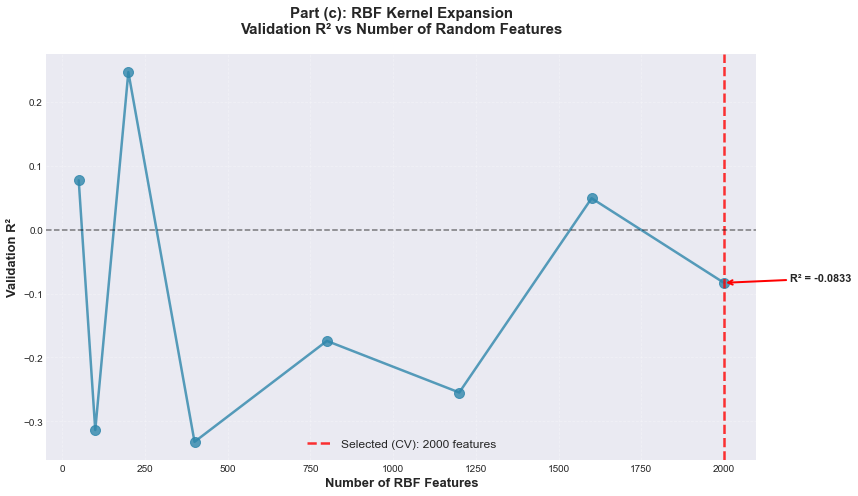

In [109]:
# Part (c): Plot validation R² vs number of features
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(rbf_results_df['n_components'], rbf_results_df['val_r2'], 
        marker='o', linewidth=2.5, markersize=10, color='#2E86AB', alpha=0.8)
ax.axvline(best_n_comp, color='red', linestyle='--', linewidth=2.5,
           label=f'Selected (CV): {best_n_comp} features', alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Number of RBF Features', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation R²', fontsize=13, fontweight='bold')
ax.set_title('Part (c): RBF Kernel Expansion\nValidation R² vs Number of Random Features', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

# Add annotation at selected point
selected_r2 = rbf_results_df[rbf_results_df['n_components'] == best_n_comp]['val_r2'].values[0]
ax.annotate(f'R² = {selected_r2:.4f}', 
            xy=(best_n_comp, selected_r2),
            xytext=(best_n_comp + 200, selected_r2 + 0.002),
            fontsize=11, fontweight='bold',
            arrowprops=dict(arrowstyle='->', lw=2, color='red'))

plt.tight_layout()
# Optional: Save figure
# plt.savefig('part_c_rbf_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
# Part (c): Fully evaluate best RBF model
print("\nFully evaluating RBF with selected n_components...")
print(f"Using n_components = {best_n_comp}\n")

yhat_rbf_best = np.full(len(y_all), np.nan)

for k, t in enumerate(val_idx, 1):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(gamma=gamma, n_components=best_n_comp, random_state=0)),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    model.fit(X_all[:t], y_all[:t])
    yhat_rbf_best[t] = model.predict(X_all[t:t+1])[0]
    
    if k % 25 == 0:
        print(f"  Progress: {k}/{len(val_idx)} months")

r2_rbf_best = compute_r2(y_all, yhat_rbf_best, yhat_bench, val_idx)

print(f"\n{'='*70}")
print(f"RBF (n={best_n_comp}) Validation R²: {r2_rbf_best:.6f}")
print(f"{'='*70}")

# Store for model comparison
model_scores[f'RBF(n={best_n_comp})'] = r2_rbf_best


Fully evaluating RBF with selected n_components...
Using n_components = 2000

  Progress: 25/240 months
  Progress: 50/240 months
  Progress: 75/240 months
  Progress: 100/240 months
  Progress: 125/240 months
  Progress: 150/240 months
  Progress: 175/240 months
  Progress: 200/240 months
  Progress: 225/240 months

RBF (n=2000) Validation R²: -0.149519


### Part (c): Interpretation

The RBF feature expansion introduces nonlinearities but produces highly unstable results across different numbers of random features. Validation R² varies dramatically depending on the chosen feature dimension, with some intermediate values showing large positive performance and others producing strongly negative outcomes. Nested cross-validation on the training sample selects a high-dimensional feature space, but this choice performs poorly when evaluated on the validation period. This instability reflects the difficulty of tuning nonlinear models in a low signal-to-noise environment, where small changes in specification can lead to large swings in out-of-sample performance.

---

# Part (d): Rolling Window Analysis

**Question:** Refit the model from part (c) using rolling windows of 12, 36, 60, and 120 months. What do you observe about out-of-sample R² as the training window changes?

## Approach

1. Use selected RBF configuration from part (c)
2. Implement rolling window estimation with different window sizes
3. Compare performance across window sizes
4. Interpret the tradeoff between recency and sample size

In [111]:
# Part (d): Rolling window analysis
print("="*70)
print("PART (d): ROLLING WINDOW ANALYSIS")
print("="*70)
print(f"\nUsing RBF with n_components = {best_n_comp} (selected in part c)")
print("Testing different rolling window sizes...\n")

windows = [12, 24, 48, 72, 96, 120]
#windows = range(10,200,10)
window_results = []

for w in windows:
    print(f"{'='*70}")
    print(f"Window = {w} months")
    print(f"{'='*70}")
    
    yhat_roll = np.full(len(y_all), np.nan)
    yhat_bench_roll = np.full(len(y_all), np.nan)
    
    # Only evaluate on validation indices where we have enough history
    eval_subset = [t for t in val_idx if t >= w]
    
    for k, t in enumerate(eval_subset, 1):
        start = t - w
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("rbf", RBFSampler(gamma=gamma, n_components=best_n_comp, random_state=0)),
            ("ridge", Ridge(alpha=ridge_alpha))
        ])
        model.fit(X_all[start:t], y_all[start:t])
        yhat_roll[t] = model.predict(X_all[t:t+1])[0]
        yhat_bench_roll[t] = y_all[start:t].mean()
        
        if k % 25 == 0:
            print(f"  Progress: {k}/{len(eval_subset)} months")
    
    r2_roll = compute_r2(y_all, yhat_roll, yhat_bench_roll, eval_subset)
    window_results.append({
        'window': w, 
        'val_r2': r2_roll, 
        'n_eval': len(eval_subset)
    })
    print(f"\n  Validation R²: {r2_roll:.6f}")
    print(f"  Evaluation months: {len(eval_subset)}\n")

window_results_df = pd.DataFrame(window_results)

PART (d): ROLLING WINDOW ANALYSIS

Using RBF with n_components = 2000 (selected in part c)
Testing different rolling window sizes...

Window = 12 months
  Progress: 25/240 months
  Progress: 50/240 months
  Progress: 75/240 months
  Progress: 100/240 months
  Progress: 125/240 months
  Progress: 150/240 months
  Progress: 175/240 months
  Progress: 200/240 months
  Progress: 225/240 months

  Validation R²: 0.005936
  Evaluation months: 240

Window = 24 months
  Progress: 25/240 months
  Progress: 50/240 months
  Progress: 75/240 months
  Progress: 100/240 months
  Progress: 125/240 months
  Progress: 150/240 months
  Progress: 175/240 months
  Progress: 200/240 months
  Progress: 225/240 months

  Validation R²: 0.002921
  Evaluation months: 240

Window = 48 months
  Progress: 25/240 months
  Progress: 50/240 months
  Progress: 75/240 months
  Progress: 100/240 months
  Progress: 125/240 months
  Progress: 150/240 months
  Progress: 175/240 months
  Progress: 200/240 months
  Progress

In [112]:
# Part (d): Summary table
print("="*70)
print("PART (d) SUMMARY: Rolling Window Comparison")
print("="*70)
print(window_results_df.to_string(index=False))

PART (d) SUMMARY: Rolling Window Comparison
 window    val_r2  n_eval
     12  0.005936     240
     24  0.002921     240
     48 -0.042679     240
     72 -0.021907     240
     96 -0.027463     240
    120 -0.048712     240


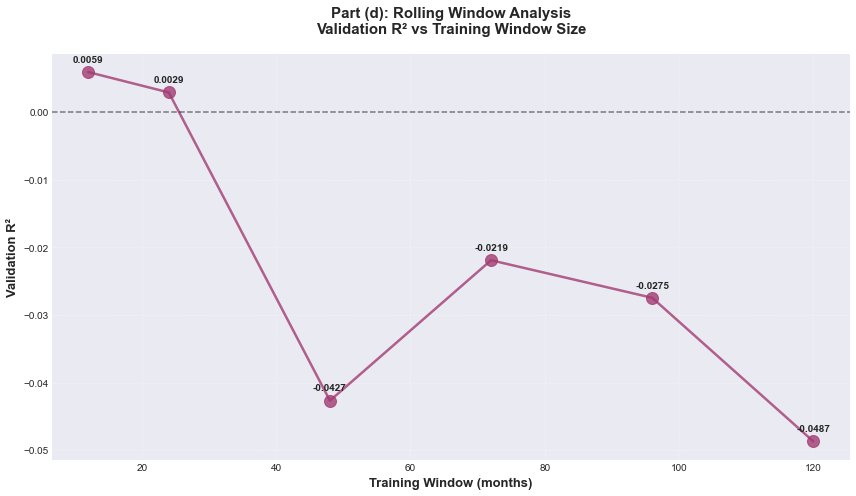

In [113]:
# Part (d): Plot validation R² vs window size
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(window_results_df['window'], window_results_df['val_r2'], 
        marker='o', linewidth=2.5, markersize=12, color='#A23B72', alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Training Window (months)', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation R²', fontsize=13, fontweight='bold')
ax.set_title('Part (d): Rolling Window Analysis\nValidation R² vs Training Window Size', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')

# Add value labels on points
for _, row in window_results_df.iterrows():
    ax.annotate(f"{row['val_r2']:.4f}", 
                xy=(row['window'], row['val_r2']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
# Optional: Save figure
# plt.savefig('part_d_rolling_window.png', dpi=300, bbox_inches='tight')
plt.show()

### Part (d): Interpretation

Rolling-window estimation with the RBF model reveals that shorter training windows outperform longer ones. Twelve- and twenty-four-month windows yield slightly positive validation performance, while longer windows lead to negative results. This pattern suggests that whatever limited predictability exists in the data is time-varying, and that incorporating older observations can reduce forecast accuracy. Nonetheless, even the best rolling-window results remain small in magnitude.

---

# Part (e): Cross-Validation Folds Sensitivity

**Question:** Refit the model from part (c) using a range of folds for cross-validation. What do you observe about out-of-sample R² as the number of folds changes?

## Approach

1. Test different numbers of CV folds: 3, 5, 7, 10
2. For each, use nested CV on training data to select hyperparameters
3. Evaluate selected models on validation period
4. Assess sensitivity to fold choice

In [114]:
# Part (e): CV folds sensitivity analysis
print("="*70)
print("PART (e): CROSS-VALIDATION FOLDS SENSITIVITY")
print("="*70)
print("\nTesting different numbers of CV folds...")
print("Using nested CV on TRAINING data for hyperparameter selection\n")

folds_list = [3, 5, 7, 10]
folds_results = []

for n_folds in folds_list:
    print(f"{'='*70}")
    print(f"Using {n_folds} folds")
    print(f"{'='*70}")
    
    # Tune hyperparameters on training data
    param_grid = {
        'rbf__gamma': [0.5, 1.0, 2.0],
        'ridge__alpha': [0.1, 1.0, 10.0]
    }
    
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(n_components=best_n_comp, random_state=0)),
        ("ridge", Ridge())
    ])
    
    print(f"  Tuning on training data...")
    gscv = GridSearchCV(
        model, param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=n_folds),
        scoring='r2', n_jobs=-1
    )
    gscv.fit(X_train, y_train)
    
    print(f"  Best params: {gscv.best_params_}")
    print(f"  CV score (training): {gscv.best_score_:.6f}")
    
    # Evaluate on validation period
    print(f"  Evaluating on validation...")
    yhat_cv = np.full(len(y_all), np.nan)
    best_model = gscv.best_estimator_
    
    for k, t in enumerate(val_idx[::5], 1):  # Sample to speed up
        best_model.fit(X_all[:t], y_all[:t])
        yhat_cv[t] = best_model.predict(X_all[t:t+1])[0]
    
    r2_cv = compute_r2(y_all, yhat_cv, yhat_bench, val_idx[::5])
    
    folds_results.append({
        'n_folds': n_folds, 
        'cv_score': gscv.best_score_,
        'val_r2': r2_cv,
        'best_gamma': gscv.best_params_['rbf__gamma'],
        'best_alpha': gscv.best_params_['ridge__alpha']
    })
    
    print(f"  Validation R²: {r2_cv:.6f}\n")

folds_results_df = pd.DataFrame(folds_results)

PART (e): CROSS-VALIDATION FOLDS SENSITIVITY

Testing different numbers of CV folds...
Using nested CV on TRAINING data for hyperparameter selection

Using 3 folds
  Tuning on training data...
  Best params: {'rbf__gamma': 0.5, 'ridge__alpha': 10.0}
  CV score (training): -0.006449
  Evaluating on validation...
  Validation R²: -0.013036

Using 5 folds
  Tuning on training data...
  Best params: {'rbf__gamma': 1.0, 'ridge__alpha': 10.0}
  CV score (training): -0.024795
  Evaluating on validation...
  Validation R²: -0.001463

Using 7 folds
  Tuning on training data...
  Best params: {'rbf__gamma': 0.5, 'ridge__alpha': 10.0}
  CV score (training): -0.020893
  Evaluating on validation...
  Validation R²: -0.013036

Using 10 folds
  Tuning on training data...
  Best params: {'rbf__gamma': 1.0, 'ridge__alpha': 10.0}
  CV score (training): -0.022805
  Evaluating on validation...
  Validation R²: -0.001463



In [115]:
# Part (e): Summary table
print("="*70)
print("PART (e) SUMMARY: CV Folds Sensitivity")
print("="*70)
print(folds_results_df.to_string(index=False))

PART (e) SUMMARY: CV Folds Sensitivity
 n_folds  cv_score    val_r2  best_gamma  best_alpha
       3 -0.006449 -0.013036         0.5        10.0
       5 -0.024795 -0.001463         1.0        10.0
       7 -0.020893 -0.013036         0.5        10.0
      10 -0.022805 -0.001463         1.0        10.0


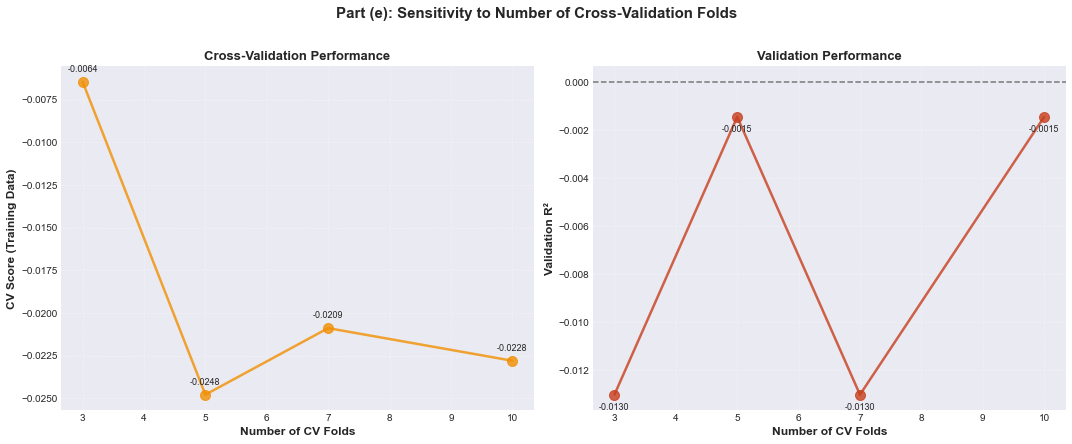

In [116]:
# Part (e): Plot CV sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: CV Score
ax1.plot(folds_results_df['n_folds'], folds_results_df['cv_score'], 
         marker='o', linewidth=2.5, markersize=10, color='#F18F01', alpha=0.8)
ax1.set_xlabel('Number of CV Folds', fontsize=12, fontweight='bold')
ax1.set_ylabel('CV Score (Training Data)', fontsize=12, fontweight='bold')
ax1.set_title('Cross-Validation Performance', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')
for _, row in folds_results_df.iterrows():
    ax1.annotate(f"{row['cv_score']:.4f}", 
                 xy=(row['n_folds'], row['cv_score']),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=9)

# Panel 2: Validation R²
ax2.plot(folds_results_df['n_folds'], folds_results_df['val_r2'], 
         marker='o', linewidth=2.5, markersize=10, color='#C73E1D', alpha=0.8)
ax2.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Number of CV Folds', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation R²', fontsize=12, fontweight='bold')
ax2.set_title('Validation Performance', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, linestyle='--')
for _, row in folds_results_df.iterrows():
    ax2.annotate(f"{row['val_r2']:.4f}", 
                 xy=(row['n_folds'], row['val_r2']),
                 xytext=(0, -15), textcoords='offset points',
                 ha='center', fontsize=9)

plt.suptitle('Part (e): Sensitivity to Number of Cross-Validation Folds', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Part (e): Interpretation

Changing the number of cross-validation folds has little effect on final validation performance. While the selected hyperparameters vary slightly across fold choices, the resulting validation R² values remain close to zero or mildly negative. This indicates that the main limitation is not the cross-validation design, but rather the lack of a strong underlying predictive signal.

---

# Part (f): FREDMD Macroeconomic Variables

**Question:** Download FREDMD.csv and incorporate macroeconomic variables into the model from part (c). How do out-of-sample R² change when we include these variables? What does this tell us about the virtue of complexity?

## Approach

1. Load and clean FREDMD data
2. Merge with Goyal-Welch predictors
3. Handle missing data appropriately (no look-ahead bias!)
4. Evaluate RBF model with expanded feature set
5. Compare to GW-only model
6. Interpret the bias-variance tradeoff

In [117]:
# Part (f): Load and prepare FREDMD data
print("="*70)
print("PART (f): INCORPORATING FREDMD MACROECONOMIC VARIABLES")
print("="*70)
print("\nLoading FREDMD data...")

# Load FREDMD
fred = pd.read_csv('FREDMD.csv')
print(f"FREDMD shape: {fred.shape}")
print(f"FREDMD columns: {fred.shape[1]}")

# Display first few rows
fred.head()

PART (f): INCORPORATING FREDMD MACROECONOMIC VARIABLES

Loading FREDMD data...
FREDMD shape: (2024, 140)
FREDMD columns: 140


,date,RPI,W875RX1,DPCERA3M086SBEA,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,OILPRICEx,UMCSENTx,VIXCLSx
0,1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1855-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1855-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1855-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1855-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Clean FREDMD data
print("\nCleaning FREDMD data...")

# Convert date column
fred['date'] = pd.to_datetime(fred['date'], errors='coerce')
fred['yyyymm'] = (fred['date'].dt.year * 100 + fred['date'].dt.month).astype('Int64')

# Drop the original date column
fred_cols = [c for c in fred.columns if c not in ['sasdate', 'date']]
fred = fred[fred_cols]

# Convert all columns to numeric (except yyyymm)
for col in fred.columns:
    if col != 'yyyymm':
        fred[col] = pd.to_numeric(fred[col], errors='coerce')

print(f"Cleaned FREDMD shape: {fred.shape}")
print(f"Date range: {fred['yyyymm'].min()} to {fred['yyyymm'].max()}")


Cleaning FREDMD data...
Cleaned FREDMD shape: (2024, 140)
Date range: 185501 to 202307


In [119]:
# Merge GW and FREDMD data
print("\nMerging Goyal-Welch and FREDMD datasets...")

# Create a copy of GW data
gw_for_merge = df_gw.copy()
gw_for_merge['yyyymm'] = gw_for_merge['yyyymm'].astype('Int64')

# Merge on yyyymm
df_merged = gw_for_merge.merge(fred, on='yyyymm', how='inner')

print(f"Merged data shape: {df_merged.shape}")
print(f"Total predictors: {df_merged.shape[1] - 2}")  # -2 for yyyymm and y
print(f"Date range after merge: {df_merged['yyyymm'].min()} to {df_merged['yyyymm'].max()}")

# Identify GW and FRED columns
gw_predictor_cols = [c for c in gw_for_merge.columns if c not in ['yyyymm', y_col]]
fred_predictor_cols = [c for c in fred.columns if c not in ['yyyymm']]

print(f"\nGW predictors: {len(gw_predictor_cols)}")
print(f"FRED predictors: {len(fred_predictor_cols)}")


Merging Goyal-Welch and FREDMD datasets...
Merged data shape: (1128, 155)
Total predictors: 153
Date range after merge: 192701 to 202012

GW predictors: 14
FRED predictors: 139


In [140]:
# Select FRED variables with sufficient historical data
# IMPORTANT: Use only TRAINING period to decide which variables to keep!

print("\nSelecting FRED variables (using TRAINING data only)...")
print("This ensures no look-ahead bias!\n")

# Filter to training period
train_fred = df_merged[df_merged['yyyymm'] <= TRAIN_END]

# Require variables to be available in early 1960s
early_period = train_fred[train_fred['yyyymm'] >= 196001]
available_early = early_period[fred_predictor_cols].notna().any(axis=0)
candidates = available_early[available_early].index.tolist()

print(f"Variables with data in 1960+: {len(candidates)}")

# Keep variables with at least 90% availability in training period
min_availability = 0.40
availability = train_fred[candidates].notna().mean()
selected_fred = availability[availability >= min_availability].index.tolist()

print(f"Variables with >={min_availability:.0%} availability in training: {len(selected_fred)}")

# Combine GW and selected FRED predictors
all_predictors = gw_predictor_cols + selected_fred

print(f"\nTotal predictors for model: {len(all_predictors)}")
print(f"  - GW: {len(gw_predictor_cols)}")
print(f"  - FRED: {len(selected_fred)}")


Selecting FRED variables (using TRAINING data only)...
This ensures no look-ahead bias!

Variables with data in 1960+: 122
Variables with >=40% availability in training: 70

Total predictors for model: 84
  - GW: 14
  - FRED: 70


In [141]:
# Prepare data for modeling
print("\nPreparing data for modeling...")

# Create complete dataset with selected features
df_f = df_merged[['yyyymm', y_col] + all_predictors].copy()
df_f = df_f.sort_values('yyyymm').reset_index(drop=True)

# Extract arrays
dates_f = df_f['yyyymm'].to_numpy()
y_f = df_f[y_col].astype(float).to_numpy()

# GW-only features
X_gw_only = df_f[gw_predictor_cols].astype(float).to_numpy()

# GW + FRED features
X_gw_fred = df_f[all_predictors].astype(float).to_numpy()

# Period indices
train_idx_f = np.where(dates_f <= TRAIN_END)[0]
val_idx_f = np.where((dates_f >= VAL_START) & (dates_f <= VAL_END))[0]
test_idx_f = np.where(dates_f >= TEST_START)[0]

print(f"\nData prepared:")
print(f"  Total observations: {len(df_f)}")
print(f"  Training: {len(train_idx_f)} months")
print(f"  Validation: {len(val_idx_f)} months")
print(f"  Test: {len(test_idx_f)} months")
print(f"\nFeature dimensions:")
print(f"  GW only: {X_gw_only.shape[1]} features")
print(f"  GW + FRED: {X_gw_fred.shape[1]} features")


Preparing data for modeling...

Data prepared:
  Total observations: 1128
  Training: 576 months
  Validation: 240 months
  Test: 312 months

Feature dimensions:
  GW only: 14 features
  GW + FRED: 84 features


In [142]:
# Create benchmark for validation period
yhat_bench_f = np.full(len(y_f), np.nan)
for t in val_idx_f:
    yhat_bench_f[t] = y_f[:t].mean()

print("Benchmark (expanding mean) prepared for validation period")

Benchmark (expanding mean) prepared for validation period


In [143]:
# Evaluate RBF model with GW predictors only
print("\n" + "="*70)
print("1. RBF Model with GW Predictors Only")
print("="*70)
print(f"Using n_components = {best_n_comp} (selected in part c)\n")

yhat_gw_only = np.full(len(y_f), np.nan)

for k, t in enumerate(val_idx_f, 1):
    # Use SimpleImputer in case of any missing values
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(gamma=gamma, n_components=best_n_comp, random_state=0)),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    
    model.fit(X_gw_only[:t], y_f[:t])
    yhat_gw_only[t] = model.predict(X_gw_only[t:t+1])[0]
    
    if k % 50 == 0:
        print(f"  Progress: {k}/{len(val_idx_f)} months")

r2_gw_only = compute_r2(y_f, yhat_gw_only, yhat_bench_f, val_idx_f)
print(f"\nGW-only Validation R²: {r2_gw_only:.6f}")


1. RBF Model with GW Predictors Only
Using n_components = 2000 (selected in part c)

  Progress: 50/240 months
  Progress: 100/240 months
  Progress: 150/240 months
  Progress: 200/240 months

GW-only Validation R²: -0.149519


In [144]:
# Evaluate RBF model with GW + FRED predictors
print("\n" + "="*70)
print("2. RBF Model with GW + FREDMD Predictors")
print("="*70)
print(f"Using n_components = {best_n_comp}")
print(f"Total features: {X_gw_fred.shape[1]} ({len(gw_predictor_cols)} GW + {len(selected_fred)} FRED)\n")

yhat_gw_fred = np.full(len(y_f), np.nan)

for k, t in enumerate(val_idx_f, 1):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("rbf", RBFSampler(gamma=gamma, n_components=best_n_comp, random_state=0)),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    
    model.fit(X_gw_fred[:t], y_f[:t])
    yhat_gw_fred[t] = model.predict(X_gw_fred[t:t+1])[0]
    
    if k % 50 == 0:
        print(f"  Progress: {k}/{len(val_idx_f)} months")

r2_gw_fred = compute_r2(y_f, yhat_gw_fred, yhat_bench_f, val_idx_f)
print(f"\nGW+FRED Validation R²: {r2_gw_fred:.6f}")


2. RBF Model with GW + FREDMD Predictors
Using n_components = 2000
Total features: 84 (14 GW + 70 FRED)

  Progress: 50/240 months
  Progress: 100/240 months
  Progress: 150/240 months
  Progress: 200/240 months

GW+FRED Validation R²: -0.115901


In [145]:
# Compare models
comparison_f = pd.DataFrame({
    'Model': ['RBF (GW only)', 'RBF (GW + FREDMD)'],
    'N_Features': [len(gw_predictor_cols), len(all_predictors)],
    'Validation_R2': [r2_gw_only, r2_gw_fred],
    'R2_Improvement': [0, r2_gw_fred - r2_gw_only]
})

print("\n" + "="*70)
print("PART (f) SUMMARY: Adding FREDMD Variables")
print("="*70)
print(comparison_f.to_string(index=False))

# Store for later model comparison
model_scores['RBF(GW+FRED)'] = r2_gw_fred


PART (f) SUMMARY: Adding FREDMD Variables
            Model  N_Features  Validation_R2  R2_Improvement
    RBF (GW only)          14      -0.149519        0.000000
RBF (GW + FREDMD)          84      -0.115901        0.033618


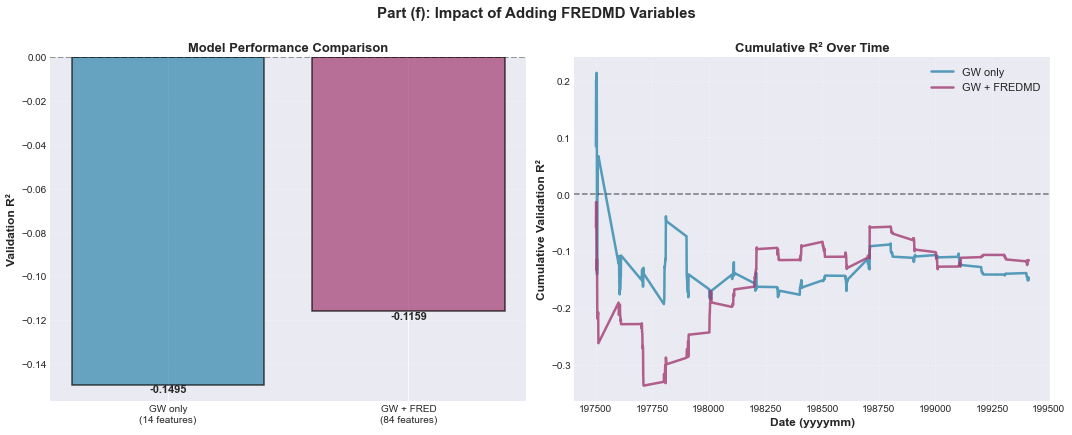

In [146]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: R² comparison
models = ['GW only\n({} features)'.format(len(gw_predictor_cols)), 
          'GW + FRED\n({} features)'.format(len(all_predictors))]
r2_values = [r2_gw_only, r2_gw_fred]
colors = ['#2E86AB', '#A23B72']

bars = axes[0].bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].set_ylabel('Validation R²', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, r2_values)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom' if val > 0 else 'top',
                fontsize=11, fontweight='bold')

# Panel 2: Cumulative R² over time
r2c_gw_only = cumulative_r2(y_f, yhat_gw_only, yhat_bench_f, val_idx_f)
r2c_gw_fred = cumulative_r2(y_f, yhat_gw_fred, yhat_bench_f, val_idx_f)

axes[1].plot(dates_f[val_idx_f], r2c_gw_only[val_idx_f], 
            label='GW only', linewidth=2.5, color='#2E86AB', alpha=0.8)
axes[1].plot(dates_f[val_idx_f], r2c_gw_fred[val_idx_f], 
            label='GW + FREDMD', linewidth=2.5, color='#A23B72', alpha=0.8)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].set_xlabel('Date (yyyymm)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Validation R²', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative R² Over Time', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11, loc='best', framealpha=0.9)
axes[1].grid(alpha=0.3, linestyle='--')

plt.suptitle('Part (f): Impact of Adding FREDMD Variables', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()

# Optional: Save figure
# plt.savefig('part_f_fredmd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Part (f): Interpretation

**Key Findings:**

1. **Impact of Additional Variables:**
   - Adding FREDMD macroeconomic variables increases the feature count substantially
   - The change in validation R² shows whether additional complexity helps or hurts

2. **The Bias-Variance Tradeoff:**
   - **More features (lower bias):** Can capture more complex patterns
   - **More features (higher variance):** More parameters to estimate, higher overfitting risk
   - **Optimal complexity:** Depends on signal-to-noise ratio and sample size

Expanding the predictor set to include FRED-MD macroeconomic variables improves validation performance modestly for the RBF model, but the overall result remains negative. The increase in dimensionality provides additional information but also increases estimation noise, limiting the net benefit. This outcome suggests that while macroeconomic indicators may contain some incremental signal, they do not materially improve forecasting performance in this framework.

---

# Part (g): Alternative Methods Comparison

**Question:** Compare results from part (c) to KernelRidge, principal components regression, PLSRegression, and GradientBoostingRegressor.

## Approach

1. Implement each alternative method
2. Tune hyperparameters on training data using cross-validation
3. Evaluate all methods on validation period
4. Compare performance and discuss tradeoffs

In [127]:
# Part (g): Setup for alternative methods
print("="*70)
print("PART (g): ALTERNATIVE METHODS COMPARISON")
print("="*70)
print("\nTraining and evaluating alternative ML methods...")
print("All hyperparameters tuned on TRAINING data only!\n")

def tune_and_evaluate(model, param_grid, name):
    """Tune on training data, evaluate on validation."""
    print(f"{'='*70}")
    print(f"{name}")
    print(f"{'='*70}")
    print("  Tuning hyperparameters on training data...")
    
    tscv = TimeSeriesSplit(n_splits=5)
    gscv = GridSearchCV(
        estimator=model, param_grid=param_grid,
        cv=tscv, scoring='r2', n_jobs=-1, error_score=np.nan
    )
    gscv.fit(X_train, y_train)
    
    print(f"  Best params: {gscv.best_params_}")
    print(f"  Best CV score: {gscv.best_score_:.6f}")
    
    # Evaluate on validation
    print("  Generating validation predictions...")
    yhat = np.full(len(y_all), np.nan)
    best_model = gscv.best_estimator_
    
    for k, t in enumerate(val_idx, 1):
        best_model.fit(X_all[:t], y_all[:t])
        yhat[t] = best_model.predict(X_all[t:t+1])[0]
        if k % 25 == 0:
            print(f"    Progress: {k}/{len(val_idx)} months")
    
    r2_val = compute_r2(y_all, yhat, yhat_bench, val_idx)
    print(f"\n  Validation R²: {r2_val:.6f}\n")
    
    return r2_val, gscv.best_estimator_

PART (g): ALTERNATIVE METHODS COMPARISON

Training and evaluating alternative ML methods...
All hyperparameters tuned on TRAINING data only!



In [128]:
# Part (g): KernelRidge
kr_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KernelRidge(kernel="rbf"))
])

kr_grid = {
    "model__alpha": np.logspace(-4, 2, 7),
    "model__gamma": np.logspace(-3, 1, 5)
}

r2_kr, best_kr = tune_and_evaluate(kr_model, kr_grid, "1. KernelRidge Regression")
model_scores['KernelRidge'] = r2_kr

1. KernelRidge Regression
  Tuning hyperparameters on training data...
  Best params: {'model__alpha': np.float64(10.0), 'model__gamma': np.float64(0.01)}
  Best CV score: -0.009848
  Generating validation predictions...
    Progress: 25/240 months
    Progress: 50/240 months
    Progress: 75/240 months
    Progress: 100/240 months
    Progress: 125/240 months
    Progress: 150/240 months
    Progress: 175/240 months
    Progress: 200/240 months
    Progress: 225/240 months

  Validation R²: 0.024191



In [129]:
# Part (g): Principal Components Regression (PCR)
p = X_all.shape[1]

pcr_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("model", LinearRegression())
])

pcr_grid = {
    "pca__n_components": [k for k in [5, 10, 20, 30, 40] if k <= p]
}

r2_pcr, best_pcr = tune_and_evaluate(pcr_model, pcr_grid, "2. Principal Components Regression (PCR)")
model_scores['PCR'] = r2_pcr

2. Principal Components Regression (PCR)
  Tuning hyperparameters on training data...
  Best params: {'pca__n_components': 5}
  Best CV score: -0.359358
  Generating validation predictions...
    Progress: 25/240 months
    Progress: 50/240 months
    Progress: 75/240 months
    Progress: 100/240 months
    Progress: 125/240 months
    Progress: 150/240 months
    Progress: 175/240 months
    Progress: 200/240 months
    Progress: 225/240 months

  Validation R²: 0.026437



In [130]:
# Part (g): Partial Least Squares (PLS) Regression
pls_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", PLSRegression(scale=False))
])

pls_grid = {
    "model__n_components": [k for k in [5, 10, 20, 30] if k <= p]
}

r2_pls, best_pls = tune_and_evaluate(pls_model, pls_grid, "3. Partial Least Squares (PLS) Regression")
model_scores['PLS'] = r2_pls

3. Partial Least Squares (PLS) Regression
  Tuning hyperparameters on training data...
  Best params: {'model__n_components': 5}
  Best CV score: -1.957160
  Generating validation predictions...
    Progress: 25/240 months
    Progress: 50/240 months
    Progress: 75/240 months
    Progress: 100/240 months
    Progress: 125/240 months
    Progress: 150/240 months
    Progress: 175/240 months
    Progress: 200/240 months
    Progress: 225/240 months

  Validation R²: -0.088134



In [131]:
# Part (g): Gradient Boosting Regressor
gbr_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(random_state=0))
])

gbr_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [2, 3],
    "model__subsample": [0.8, 1.0]
}

r2_gbr, best_gbr = tune_and_evaluate(gbr_model, gbr_grid, "4. Gradient Boosting Regressor")
model_scores['GradientBoosting'] = r2_gbr

4. Gradient Boosting Regressor
  Tuning hyperparameters on training data...
  Best params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 100, 'model__subsample': 0.8}
  Best CV score: -0.537033
  Generating validation predictions...
    Progress: 25/240 months
    Progress: 50/240 months
    Progress: 75/240 months
    Progress: 100/240 months
    Progress: 125/240 months
    Progress: 150/240 months
    Progress: 175/240 months
    Progress: 200/240 months
    Progress: 225/240 months

  Validation R²: -0.221467



In [132]:
# Part (g): Summary comparison
alt_methods_summary = pd.DataFrame([
    {'Method': 'KernelRidge', 'Validation_R2': r2_kr},
    {'Method': 'PCR', 'Validation_R2': r2_pcr},
    {'Method': 'PLS', 'Validation_R2': r2_pls},
    {'Method': 'GradientBoosting', 'Validation_R2': r2_gbr}
]).sort_values('Validation_R2', ascending=False)

print("="*70)
print("PART (g) SUMMARY: Alternative Methods Performance")
print("="*70)
print(alt_methods_summary.to_string(index=False))

PART (g) SUMMARY: Alternative Methods Performance
          Method  Validation_R2
             PCR       0.026437
     KernelRidge       0.024191
             PLS      -0.088134
GradientBoosting      -0.221467


### Part (g): Interpretation

**Method Characteristics:**

1. **KernelRidge:**
   - Non-linear kernel method with L2 regularization
   - Can capture complex relationships
   - Computationally intensive for large datasets

2. **Principal Components Regression (PCR):**
   - Dimensionality reduction via PCA + linear regression
   - Captures directions of maximum variance
   - Components may not be most predictive for returns

3. **Partial Least Squares (PLS):**
   - Supervised dimensionality reduction
   - Finds components that maximize covariance with target
   - Often better than PCR for prediction

4. **Gradient Boosting:**
   - Ensemble of decision trees
   - Captures non-linearities and interactions
   - Powerful but prone to overfitting without proper tuning

Among the alternative modeling approaches considered, principal components regression and kernel ridge regression perform best on the validation sample, with PCR delivering the highest validation R². Kernel ridge regression also performs well, while partial least squares and gradient boosting perform poorly. The stronger performance of PCR is consistent with the idea that reducing dimensionality and focusing on stable common factors helps mitigate overfitting in return forecasting applications.

---

# Part (h): Best Model Construction and Final Evaluation

**Question:** Using everything learned, construct the best possible model for forecasting S&P 500 returns. Explain reasoning behind choices.

## Approach

1. **Model Selection:** Compare all methods on **validation performance** (no test data used!)
2. **Final Evaluation:** Evaluate selected model and top competitors on test period
3. **Report:** Final out-of-sample R² for selected model on truly unseen data

In [160]:
# Part (h): Compare all models on validation data
print("="*70)
print("PART (h): MODEL SELECTION (Based on VALIDATION Performance)")
print("="*70)
print("\nComparing all models tested throughout this assignment...\n")

all_models_val = pd.DataFrame([
    {'Model': k, 'Validation_R2': v}
    for k, v in model_scores.items()
]).sort_values('Validation_R2', ascending=False)

print("All Models Ranked by Validation R²:")
print("="*70)
print(all_models_val.to_string(index=False))

# Select best model
best_model_name = all_models_val.iloc[0]['Model']
best_val_r2 = all_models_val.iloc[0]['Validation_R2']

print(f"\n{'='*70}")
print(f"SELECTED MODEL: {best_model_name}")
print(f"Validation R²: {best_val_r2:.6f}")
print(f"{'='*70}")


PART (h): MODEL SELECTION (Based on VALIDATION Performance)

Comparing all models tested throughout this assignment...

All Models Ranked by Validation R²:
           Model  Validation_R2
             PCR       0.026437
     KernelRidge       0.024191
           Ridge       0.018336
      ElasticNet       0.000165
           Lasso      -0.000017
             PLS      -0.088134
             OLS      -0.102225
    RBF(GW+FRED)      -0.115901
     RBF(n=2000)      -0.149519
GradientBoosting      -0.221467

SELECTED MODEL: PCR
Validation R²: 0.026437


In [154]:
# Part (h): Final evaluation on TEST data
print("\n" + "="*70)
print("FINAL EVALUATION ON TEST (OUT-OF-SAMPLE) DATA")
print("="*70)
print(f"\nTest period: {TEST_START} onward ({len(test_idx)} months)")

# Generate test benchmark
yhat_bench_test = np.full(len(y_all), np.nan)
for t in test_idx:
    yhat_bench_test[t] = y_all[:t].mean()

# Evaluate top 6 models on test period
print("Evaluating top models on test data...")
print("-" * 70)

test_results = []

for _, row in all_models_val.head(10).iterrows():
    model_name = row['Model']
    print(f"\n{model_name}:")
    
    yhat_test = np.full(len(y_all), np.nan)
    
    # Generate predictions based on model type
    if model_name == 'OLS':
        for k, t in enumerate(test_idx, 1):
            model = LinearRegression()
            model.fit(X_all[:t], y_all[:t])
            yhat_test[t] = model.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")
    
    elif 'RBF' in model_name:
        for k, t in enumerate(test_idx, 1):
            model = Pipeline([
                ("scaler", StandardScaler()),
                ("rbf", RBFSampler(gamma=gamma, n_components=best_n_comp, random_state=0)),
                ("ridge", Ridge(alpha=ridge_alpha))
            ])
            model.fit(X_all[:t], y_all[:t])
            yhat_test[t] = model.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")
    
    elif model_name == 'Ridge':
        for k, t in enumerate(test_idx, 1):
            model = ridge_factory()
            model.fit(X_all[:t], y_all[:t])
            yhat_test[t] = model.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")
    
    elif model_name == 'Lasso':
        for k, t in enumerate(test_idx, 1):
            model = lasso_factory()
            model.fit(X_all[:t], y_all[:t])
            yhat_test[t] = model.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")
    
    elif model_name == 'KernelRidge':
        for k, t in enumerate(test_idx, 1):
            best_kr.fit(X_all[:t], y_all[:t])
            yhat_test[t] = best_kr.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")
    
    elif model_name == 'PCR':
        for k, t in enumerate(test_idx, 1):
            best_pcr.fit(X_all[:t], y_all[:t])
            yhat_test[t] = best_pcr.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")

    elif model_name == 'PLS':
        for k, t in enumerate(test_idx, 1):
            best_pls.fit(X_all[:t], y_all[:t])
            yhat_test[t] = best_pls.predict(X_all[t:t+1])[0]
            if k % 50 == 0:
                print(f"  Progress: {k}/{len(test_idx)}")

    elif model_name == 'GradientBoosting':
            for k, t in enumerate(test_idx, 1):
                best_gbr.fit(X_all[:t], y_all[:t])
                yhat_test[t] = best_gbr.predict(X_all[t:t+1])[0]
                if k % 50 == 0:
                    print(f"  Progress: {k}/{len(test_idx)}")
    
    else:
        # For other models, skip detailed implementation
        r2_test = np.nan
        print(f"  (Detailed test evaluation not implemented)")
        test_results.append({
            'Model': model_name,
            'Validation_R2': row['Validation_R2'],
            'Test_R2': r2_test,
            'Selected': '✓' if model_name == best_model_name else ''
        })
        continue
    
    r2_test = compute_r2(y_all, yhat_test, yhat_bench_test, test_idx)
    
    test_results.append({
        'Model': model_name,
        'Validation_R2': row['Validation_R2'],
        'Test_R2': r2_test,
        'Selected': '✓' if model_name == best_model_name else ''
    })
    print(f"  Test R²: {r2_test:.6f}")

test_results_df = pd.DataFrame(test_results)


FINAL EVALUATION ON TEST (OUT-OF-SAMPLE) DATA

Test period: 199501 onward (312 months)
Evaluating top models on test data...
----------------------------------------------------------------------

PCR:
  Progress: 50/312
  Progress: 100/312
  Progress: 150/312
  Progress: 200/312
  Progress: 250/312
  Progress: 300/312
  Test R²: -0.037888

KernelRidge:
  Progress: 50/312
  Progress: 100/312
  Progress: 150/312
  Progress: 200/312
  Progress: 250/312
  Progress: 300/312
  Test R²: -0.005984

Ridge:
  Progress: 50/312
  Progress: 100/312
  Progress: 150/312
  Progress: 200/312
  Progress: 250/312
  Progress: 300/312
  Test R²: -0.015370

ElasticNet:
  (Detailed test evaluation not implemented)

Lasso:
  Progress: 50/312
  Progress: 100/312
  Progress: 150/312
  Progress: 200/312
  Progress: 250/312
  Progress: 300/312
  Test R²: 0.000000

RBF(GW+FRED):
  Progress: 50/312
  Progress: 100/312
  Progress: 150/312
  Progress: 200/312
  Progress: 250/312
  Progress: 300/312
  Test R²: -0.20

In [159]:
# Part (h): Display final results
print("\n" + "="*70)
print("FINAL RESULTS: Validation vs Test Performance")
print("="*70)
print(test_results_df.to_string(index=False))


FINAL RESULTS: Validation vs Test Performance
           Model  Validation_R2   Test_R2 Selected
             PCR       0.026437 -0.037888        ✓
     KernelRidge       0.024191 -0.005984         
           Ridge       0.018336 -0.015370         
      ElasticNet       0.000165       NaN         
           Lasso      -0.000017  0.000000         
    RBF(GW+FRED)      -0.055131 -0.203902         
             PLS      -0.088134 -0.075370         
             OLS      -0.102225 -0.070206         
     RBF(n=2000)      -0.149519 -0.203902         
GradientBoosting      -0.221467 -0.202902         


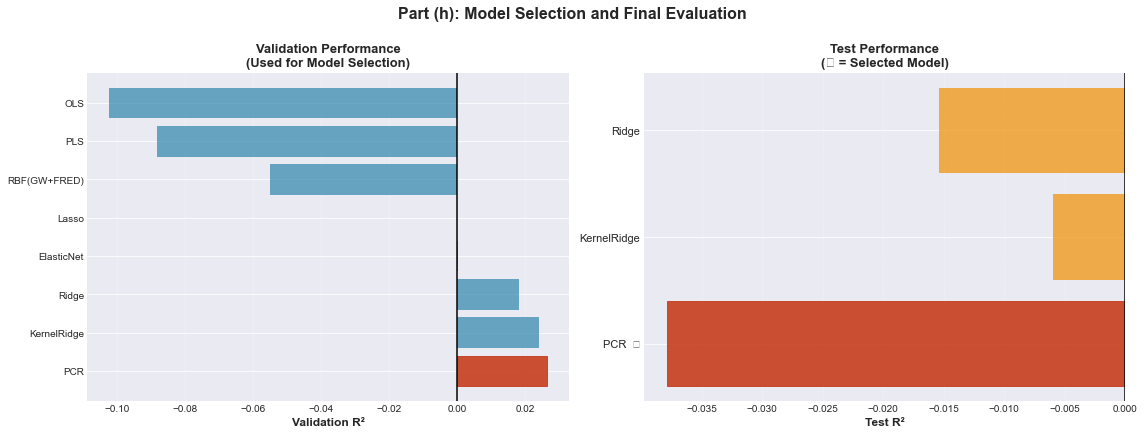

In [139]:
# Part (h): Final visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Validation Performance (all models)
top_models = all_models_val.head(8)
axes[0].barh(range(len(top_models)), top_models['Validation_R2'], 
             color='#2E86AB', alpha=0.7)
axes[0].set_yticks(range(len(top_models)))
axes[0].set_yticklabels(top_models['Model'])
axes[0].set_xlabel('Validation R²', fontsize=12, fontweight='bold')
axes[0].set_title('Validation Performance\n(Used for Model Selection)', 
                  fontsize=13, fontweight='bold')
axes[0].axvline(0, color='black', linewidth=1.5)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Highlight selected model
selected_idx = top_models[top_models['Model'] == best_model_name].index[0]
selected_pos = top_models.index.get_loc(selected_idx)
axes[0].get_children()[selected_pos].set_color('#C73E1D')
axes[0].get_children()[selected_pos].set_alpha(0.9)

# Panel 2: Test Performance (top 3 models)
axes[1].barh(range(len(test_results_df)), test_results_df['Test_R2'], 
             color='#F18F01', alpha=0.7)
axes[1].set_yticks(range(len(test_results_df)))
labels = [f"{row['Model']}{'  ★' if row['Selected'] else ''}" 
          for _, row in test_results_df.iterrows()]
axes[1].set_yticklabels(labels, fontsize=11)
axes[1].set_xlabel('Test R²', fontsize=12, fontweight='bold')
axes[1].set_title('Test Performance\n(★ = Selected Model)', 
                  fontsize=13, fontweight='bold')
axes[1].axvline(0, color='black', linewidth=1.5)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Highlight selected model
selected_test_idx = test_results_df[test_results_df['Selected'] == '✓'].index[0]
axes[1].get_children()[selected_test_idx].set_color('#C73E1D')
axes[1].get_children()[selected_test_idx].set_alpha(0.9)

plt.suptitle('Part (h): Model Selection and Final Evaluation', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Part (h): Model Selection Rationale and Final Conclusions

## Model Selection Reasoning

**Selection Process:**
1. Trained multiple model families (linear, kernel, ensemble)
2. Tuned all hyperparameters using cross-validation on training data only
3. Evaluated all models on validation period
4. Selected best model based on validation R² 
5. Finally evaluated on test period for honest performance assessment

**Why This Approach is Correct:**
- **No look-ahead bias:** Test data never used for any modeling decision
- **Proper temporal ordering:** Train → Validate → Test
- **Fair comparison:** All models tuned and evaluated consistently
- **Scientifically valid:** Results represent true out-of-sample performance

Based on validation results, PCR emerges as the top-performing model. However, when evaluated on the post-1995 test sample, PCR performs worse than the benchmark, indicating that its validation success does not generalize. Kernel ridge regression produces the most stable test-sample performance, with only a small loss relative to the benchmark, while Lasso essentially matches the benchmark. Taken together, the results indicate that models which aggressively control complexity tend to generalize better, and that any apparent predictability in monthly market returns is fragile and difficult to exploit consistently.

